# Simple Analysis

For a single DR method/classifier.

In [1]:
import sys
path_scripts = '/home/noticed/supervised-DR-for-ASP/scripts/'
sys.path.append(path_scripts)

import IS_class as ip
from IS_class import InstanceSpace
import IS_eval as ipe
from proj_set import *

import pandas as pd
import numpy as np
import pickle as pkl

import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
metadata = pd.read_csv('./metadata/tsp.csv', index_col=0)
outpath = './results/tsp_all/'
selFeats = [c for c in metadata.columns if c.startswith('feature_')]


In [3]:
selFeats

['feature_Mean_StdDevDist',
 'feature_Centroid_X',
 'feature_Centroid_Y',
 'feature_Radius',
 'feature_FracDistinctDists_1Digit',
 'feature_FracDistinctDists_2Digits',
 'feature_FracDistinctDists_3Digits',
 'feature_FracDistinctDists_4Digits',
 'feature_RectangularArea',
 'feature_VarNormalised_nNNds',
 'feature_CoeffvarNormalised_nNNds',
 'feature_NumClusters',
 'feature_CitiesModClusters',
 'feature_VarCitiesPerCluster',
 'feature_NumOutliers',
 'feature_RatioNodesNearEdgesPlane',
 'feature_MeanRadiusEachCluster']

## Using Python + R

For DA methods and sparse variants of LDA, MDA and PLS.

In [3]:
## only needed if wanting to use methods in R
# prep(metadata, selFeats, outpath, scaler='s')

To use DA method implemented in R, run either of the following in the command line **after** running `prep()` :

`./da_par.r _outpath _ncores` (for default parameters)

`./da_par.r _outpath _ncores _gridSize` (for CV search, up to `_gridSize` parameters)


In [4]:
## create instance space object and load DA proj and predictions
iSpace = InstanceSpace()
iSpace.fromMetadata(metadata, scaler='s',best='Best',source='source')
iSpace.path = outpath

iSpace.dropFeatures(selFeats)

train_ind = list(pd.read_csv(outpath + 'metadata_train.csv')['instances'])
test_ind = list(pd.read_csv(outpath + 'metadata_test.csv')['instances'])
iSpace.splitData_known(train_ind, test_ind, scale=True)

## adds both DA methods
da_proj = pd.read_csv(outpath + 'da_proj.csv')
da_list = da_proj['proj'].unique()
for da in da_list:
    iSpace.addProj(da,da_proj.loc[da_proj['proj']==da])
    

Features dropped. Remaining features: 17
Manually adding MDA_s projection
Manually adding LDA_s projection


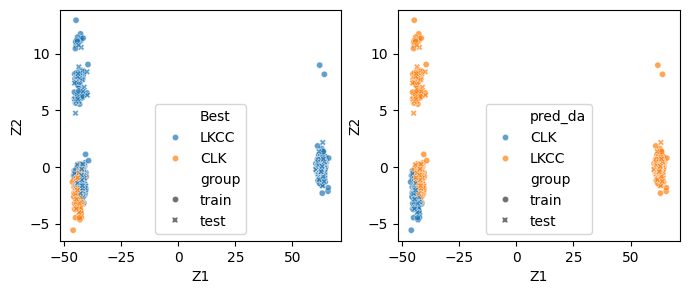

In [5]:
plt.subplots(1,2, figsize=(8,3))

plt.subplot(1,2,1)
iSpace.plot(proj='MDA_s', hue='Best')

plt.subplot(1,2,2)
iSpace.plot(proj='MDA_s', hue='pred_da')

### Prediction evaluation

In [6]:
is_pred = ipe.PredictionEval(iSpace.PlotProj, split=True)

for proj in is_pred.projections.keys():
    is_pred.evaluate_predictions(proj)
    is_pred.calc_regrets(proj,iSpace.performance,min=True,tie_lab=None)


In [7]:
pd.DataFrame.from_dict(is_pred.evals, orient='index').reset_index().rename(
        columns={'level_0':'proj', 'level_1':'pred_model','level_2':'group'}
    )

,proj,pred_model,group,accuracy,precision,precision_w,recall,recall_m,f1,f1_w
0,MDA_s,da,train,0.893421,0.770992,0.889334,0.664474,0.807566,0.824150,0.890371
1,MDA_s,da,test,0.873684,0.769231,0.866041,0.526316,0.743421,0.774525,0.864241
2,LDA_s,da,train,0.967105,0.931973,0.966819,0.901316,0.942434,0.947956,0.966898
3,LDA_s,da,test,0.984211,0.972973,0.984137,0.947368,0.970395,0.975082,0.984131


In [8]:
regretDF = pd.concat(is_pred.regrets).reset_index().rename(
        columns={'level_0':'proj', 'level_1':'pred_model','level_2':'group'}
    )

<Axes: xlabel='proj', ylabel='abs_reg'>

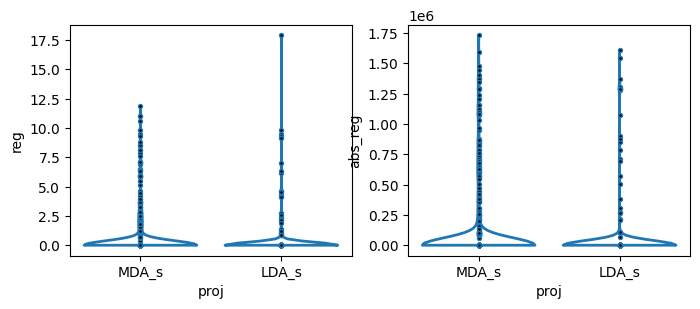

In [9]:
plt.subplots(1,2, figsize=(8,3))

plt.subplot(1,2,1)
sns.violinplot(
    data = regretDF, y='reg', x='proj',
    inner='point', 
    cut=0, density_norm='count',
    fill=False, linewidth=2,
    inner_kws={'s':8, 'color': 'black'}
)

plt.subplot(1,2,2)
sns.violinplot(
    data = regretDF, y='abs_reg', x='proj',
    inner='point', 
    cut=0, density_norm='count',
    fill=False, linewidth=2,
    inner_kws={'s':8, 'color': 'black'}
)

## Using only Python

If using a method in Python, no need to save to csv at each step:

In [7]:
iSpace = InstanceSpace()
iSpace.fromMetadata(metadata, scaler='s',best='Best',source='source')
iSpace.path = outpath
iSpace.dropFeatures(selFeats)

iSpace.splitData(test_size=0.2, random_state=1111,scale=True, stratified=True)
iSpace.PILOT(n_components=2,mode='a')

# if algo perf is very similar, rel PLS good
# iSpace.getRelativePerf(True)
# iSpace.PLS('rel',n_components=2)


Features dropped. Remaining features: 17


In [8]:
iSpace.projections.keys()

dict_keys(['PILOTa'])

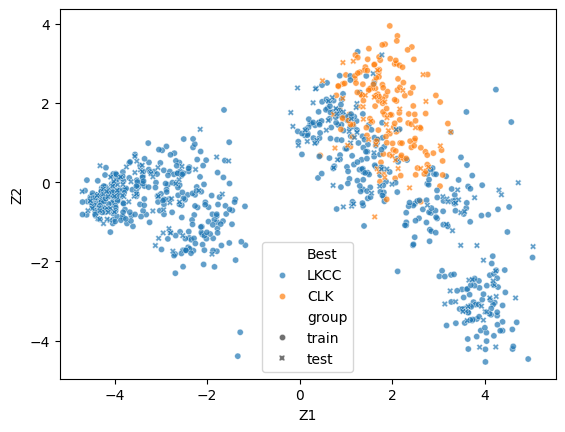

In [12]:
iSpace.plot(proj='PILOTa', hue='Best')
plt.savefig('./Plots/tsp_pilot.png', dpi=300)
# plt.subplot(1,2,2)
# iSpace.plot(proj='PILOTa', hue='pred_da')

In [14]:
iSpace.PlotProj['PILOTa']

,Z1,Z2,Best,group
instances,,,,
random_025,1.298406,2.261761,LKCC,train
LKCChard_086,2.027440,1.388526,CLK,train
LKCCeasy_020,-1.392877,-0.432340,LKCC,train
LKCCeasy_028,-3.315731,-0.817372,LKCC,train
LKCChard_002,1.632807,2.368057,CLK,train
...,...,...,...,...
LKCChard_078,1.867692,1.459294,CLK,test
CLKeasy_161,-3.524094,-0.294463,LKCC,test
LKCChard_009,1.834268,2.024413,CLK,test


In [17]:
## original features
x_all = pd.DataFrame(pd.concat([iSpace.split_data['Yb_train'],iSpace.split_data['Yb_test']]))
x_all['group'] = ['train']*len(iSpace.split_data['Yb_train'])+['test']*len(iSpace.split_data['Yb_test'])

zcols = [f'Z{i+1}' for i in range(iSpace.m)]
x_all = pd.concat([
    pd.DataFrame(np.vstack([iSpace.split_data['X_train'],iSpace.split_data['X_test']]), columns=zcols, index=x_all.index),
    x_all], axis=1)
iSpace.addProj('All', x_all, 
            {'col_names':dict(zip(zcols,iSpace.featureNames))})


Manually adding All projection


In [ ]:
## for SVM hyperparameter tuning and prediction
metadata_train = metadata.loc[iSpace.split_data['Yb_train'].index]
pred_paramDF = ipe.pred_cv_basic(metadata_train,selFeats,outpath,iSpace)
is_pred.makePredictions_svm(proj, params=pred_paramDF.loc[proj,'SVM'])


In [32]:
## predictions -- using default params
is_pred = ipe.PredictionEval(iSpace.PlotProj, split=True)
proj = 'PILOTa'

is_pred.makePredictions_svm(proj, params={})
is_pred.makePredictions_svm('All', params={})

is_pred.makePredictions_avg(avg_algo=metadata['Best'].value_counts().idxmax())
    

In [33]:
is_pred.projections['All']

,Z1,Z2,Z3,Z4,Z5,Z6,Z7,Z8,Z9,Z10,...,Z14,Z15,Z16,Z17,Best,group,pred_svm,prob_svm_CLK,prob_svm_LKCC,pred_avg
instances,,,,,,,,,,,,,,,,,,,,,
random_025,-1.329756,-0.011702,1.416425,-0.826864,0.708852,0.793736,0.809500,0.698951,-0.133483,0.605744,...,2.155943,0.889237,-0.288533,-0.486916,LKCC,train,LKCC,0.420114,0.579886,LKCC
LKCChard_086,-0.385256,-2.618853,-0.681497,-0.826861,0.882274,0.824097,0.757449,0.761733,-0.264730,0.310339,...,0.850307,0.166435,-0.000757,-0.655219,CLK,train,CLK,0.980363,0.019637,LKCC
LKCCeasy_020,-0.359731,-0.590759,-0.620860,1.132267,-1.183024,-1.193554,-1.201832,-1.202780,-1.932913,0.310391,...,-0.480249,1.467479,-0.576308,-0.799206,LKCC,train,LKCC,0.006727,0.993273,LKCC
LKCCeasy_028,0.681836,-1.714076,1.100691,1.273764,-1.167258,-1.193554,-1.202814,-1.202747,1.321271,-0.146623,...,-0.652395,-1.134609,0.747459,1.592998,LKCC,train,LKCC,0.021412,0.978588,LKCC
LKCChard_002,-0.397587,-1.707116,-1.915856,-0.826860,0.834977,0.981424,0.877265,0.746016,1.078403,1.094525,...,-0.652395,0.166435,-0.461198,0.994299,CLK,train,CLK,0.996810,0.003190,LKCC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LKCChard_078,0.133601,1.021137,1.445001,-0.826860,0.945336,0.920701,0.852712,0.811519,0.349800,0.131131,...,3.056814,-0.267247,0.171908,-0.310574,CLK,test,CLK,0.700350,0.299650,LKCC
CLKeasy_161,0.037730,-0.246248,-0.866198,1.198150,-1.214555,-1.210115,-1.197903,-1.202714,1.321271,-1.245799,...,2.326108,-1.134609,1.438120,0.165139,LKCC,test,LKCC,0.010357,0.989643,LKCC
LKCChard_009,-0.167103,-1.244287,0.727108,-0.826861,0.771914,1.025586,0.908692,0.702092,-1.087169,-0.896069,...,3.761870,-0.700928,-0.921639,-0.471034,CLK,test,CLK,0.768296,0.231704,LKCC


In [30]:
is_pred.projections['PILOTa']

,Z1,Z2,Best,group,pred_svm,prob_svm_CLK,prob_svm_LKCC
instances,,,,,,,
random_025,1.298406,2.261761,LKCC,train,CLK,8.226548e-01,0.177345
LKCChard_086,2.027440,1.388526,CLK,train,CLK,8.737899e-01,0.126210
LKCCeasy_020,-1.392877,-0.432340,LKCC,train,LKCC,1.826514e-07,1.000000
LKCCeasy_028,-3.315731,-0.817372,LKCC,train,LKCC,3.276906e-03,0.996723
LKCChard_002,1.632807,2.368057,CLK,train,CLK,9.466306e-01,0.053369
...,...,...,...,...,...,...,...
LKCChard_078,1.867692,1.459294,CLK,test,CLK,8.475751e-01,0.152425
CLKeasy_161,-3.524094,-0.294463,LKCC,test,LKCC,3.075992e-03,0.996924
LKCChard_009,1.834268,2.024413,CLK,test,CLK,9.470215e-01,0.052978


Same evaluation as before.

In [35]:
for proj in is_pred.projections.keys():
    is_pred.evaluate_predictions(proj)
    is_pred.calc_regrets(proj,iSpace.performance,min=True,tie_lab=None)


In [37]:
predEvalDF = pd.DataFrame.from_dict(is_pred.evals, orient='index').reset_index().rename(
        columns={'level_0':'proj', 'level_1':'pred_model','level_2':'group'}
    )

In [38]:
predEvalDF.query("group=='test'")

,proj,pred_model,group,accuracy,precision,precision_w,recall,recall_m,f1,f1_w
1,PILOTa,svm,test,0.878947,0.800000,0.872727,0.526316,0.746711,0.781183,0.868940
4,All,svm,test,0.921053,0.896552,0.919683,0.684211,0.832237,0.864098,0.916885
5,All,avg,test,0.800000,1.000000,0.840000,0.000000,0.500000,0.444444,0.711111


In [39]:
regretDF = pd.concat(is_pred.regrets).reset_index().rename(
        columns={'level_0':'proj', 'level_1':'pred_model','level_2':'group'}
    )

<Axes: xlabel='proj', ylabel='abs_reg'>

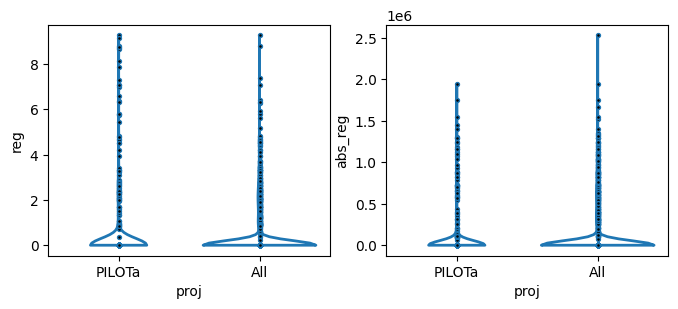

In [40]:
plt.subplots(1,2, figsize=(8,3))

plt.subplot(1,2,1)
sns.violinplot(
    data = regretDF, y='reg', x='proj',
    inner='point', 
    cut=0, density_norm='count',
    fill=False, linewidth=2,
    inner_kws={'s':8, 'color': 'black'}
)

plt.subplot(1,2,2)
sns.violinplot(
    data = regretDF, y='abs_reg', x='proj',
    inner='point', 
    cut=0, density_norm='count',
    fill=False, linewidth=2,
    inner_kws={'s':8, 'color': 'black'}
)

<Axes: xlabel='proj', ylabel='abs_reg_sub'>

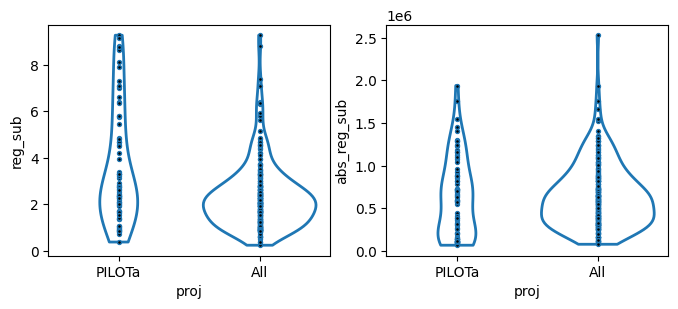

In [42]:
plt.subplots(1,2, figsize=(8,3))

plt.subplot(1,2,1)
sns.violinplot(
    data = regretDF, y='reg_sub', x='proj',
    inner='point', 
    cut=0, density_norm='count',
    fill=False, linewidth=2,
    inner_kws={'s':8, 'color': 'black'}
)

plt.subplot(1,2,2)
sns.violinplot(
    data = regretDF, y='abs_reg_sub', x='proj',
    inner='point', 
    cut=0, density_norm='count',
    fill=False, linewidth=2,
    inner_kws={'s':8, 'color': 'black'}
)

## Results from all_proj_run

In [17]:
with open(outpath +'iSpace.pkl', 'rb') as f:
    iSpace_all = pkl.load(f)

with open(outpath +'pred_eval.pkl', 'rb') as f:
    is_pred_all = pkl.load(f)

In [18]:
pred_eval_all = pd.read_csv(outpath + 'pred_eval.csv')

In [19]:
predAll_df = pred_eval_all.query('group=="test" & pred_model!="knn"')
predAll_df.index = predAll_df.apply(
    lambda x: x['proj'] if x['pred_model']=='da' else
        'Naive' if x['pred_model']=='avg' else
        f"{x['proj']}\n{x['pred_model']}", axis=1)

In [20]:
predAll_df

,proj,pred_model,group,accuracy,precision,precision_w,recall,recall_m,f1,f1_w
MDA_s,MDA_s,da,test,0.873684,0.769231,0.866041,0.526316,0.743421,0.774525,0.864241
LDA_s,LDA_s,da,test,0.984211,0.972973,0.984137,0.947368,0.970395,0.975082,0.984131
PCA\nsvm,PCA,svm,test,0.836842,0.666667,0.819724,0.368421,0.661184,0.689002,0.817657
PILOTa\nsvm,PILOTa,svm,test,0.878947,0.800000,0.872727,0.526316,0.746711,0.781183,0.868940
PLSR\nsvm,PLSR,svm,test,0.868421,0.782609,0.860713,0.473684,0.720395,0.755897,0.855337
PLSRrel\nsvm,PLSRrel,svm,test,0.889474,0.904762,0.891012,0.500000,0.743421,0.789324,0.876477
SLDA,SLDA,da,test,0.821053,0.552632,0.821053,0.552632,0.720395,0.720395,0.821053
SPLS\nsvm,SPLS,svm,test,0.868421,0.760000,0.859879,0.500000,0.730263,0.762155,0.857543
SrPLS\nsvm,SrPLS,svm,test,0.805263,0.529412,0.771778,0.236842,0.592105,0.606713,0.774378
All\nsvm,All,svm,test,0.921053,0.896552,0.919683,0.684211,0.832237,0.864098,0.916885


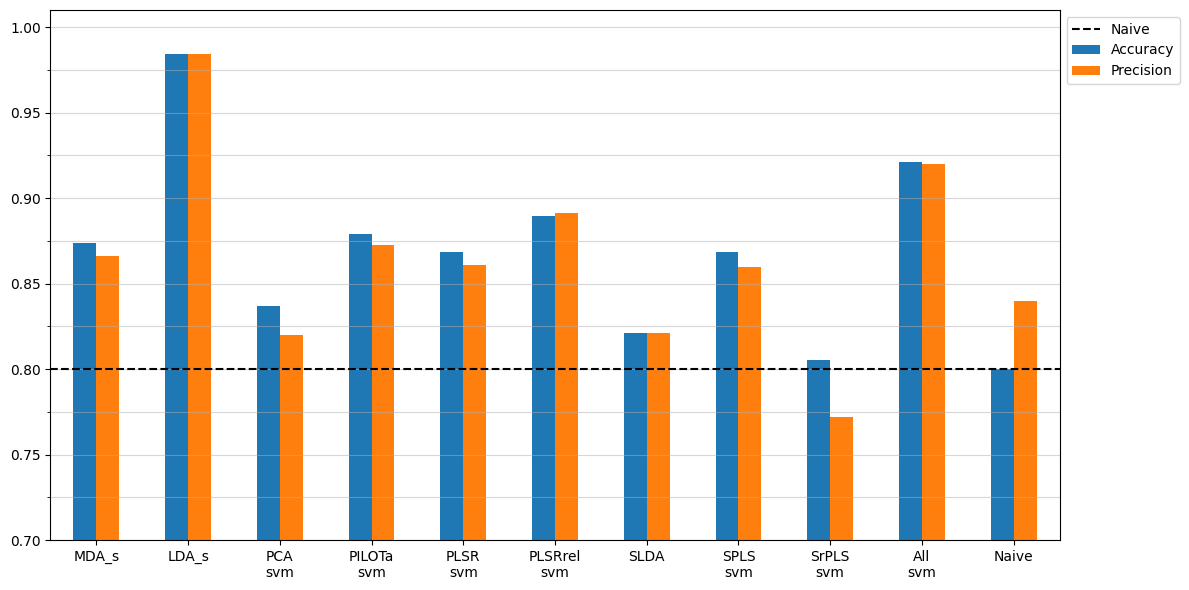

In [21]:
baseAcc = {'Naive': 0.8}
predAll_df[['accuracy','precision_w']].plot(kind='bar', figsize=(12,6),
                ylim=(0.7,1.01), xlabel='',rot=0)
# horizontal grid lines
plt.yticks(np.arange(0.7, 1.01, 0.025), minor=True)
plt.grid(axis='y', which='both', alpha=0.5)

# add horizontal line for base accuracy
plt.axhline(y=baseAcc['Naive'], color='black', linestyle='--', label='Naive')

# legend outside
# legend labels
plt.legend(['Naive','Accuracy','Precision','AUC'],bbox_to_anchor=(1, 1), loc='upper left')
#plt.legend(bbox_to_anchor=(1, 1), loc='upper left')

plt.tight_layout()

In [22]:
regretDF_all = pd.concat(is_pred_all.regrets).reset_index().rename(
        columns={'level_0':'proj', 'level_1':'pred_model','level_2':'group'}
    )